The goal of this notebook is to reproduce graphs from relevant papers to make sure that our process matches or closely matches other output. 

## Castle, et. al (2014)

In this paper, the authors focus on groundwater depletion in the Colorado River Basin. They have several charts relevant for comparisons, including one that has terrestrial water storage anomalies using GRACE data. To verify we are processing our data correctly, I will recreate the TWSA chart they have for the whole basin, pictured below: 

<p align="center">
    <img src="../notebooks-and-markdowns/whole_basin_castlepaper.png" width="800" />
</p>

A few technical things to note for their methods: 

+ They use GRACE RL05 from CSR
+ Their deviations are calculated as deviations from the mean during the study period of Jan 2003-Nov 2013
+ Since they use spherical harmonics data, their pixel size is 1 degree by 1 degree

Our process: 

+ load in GRACE
+ combine into a dataframe 
+ calculate deviation from the mean for Jan 2003-Nov 2013
+ average over the basin 
+ graph 

It's hard to find the right files in the archives to download, let's start with the version of GRACE spherical harmonics we have downloaded. 

In [1]:
# Defining path to GRACE data
#p = "/home/kmk58/remoteData/GRACE/data/TELLUS_GRAC_L3_CSR_RL06_LND_v04/"
p = '/home/kmk58/remoteData/GRACE_NEW2/TELLUS_GRAC_L3_GFZ_RL06_LND_v04/'

In [2]:
import geopandas as gpd 
import matplotlib.pyplot as plt

shpfl = gpd.read_file("/home/kmk58/remoteData/shapefiles/Colorado_River_Basin_Hydrological_Boundaries_with_Areas_served_by_Colorado_River.shp")
# Code to filter to shapefile

# extract a dataframe of the coordinates from the shapefile
coords = shpfl.get_coordinates()
# find the maximum and minimum lat/longs, corresponding to the red points on the figure above
lon_min = min(coords['x'])
lon_max = max(coords['x'])
lat_min = min(coords['y'])
lat_max = max(coords['y'])

In [3]:
import xarray as xr
import os
import pandas as pd
import numpy as np

os.environ['HDF5_USE_FILE_LOCKING']='FALSE'

crb_df = pd.DataFrame()

#Iterating through files in path
for filename in os.listdir(p):
    if filename.endswith(".nc"):
    #Reading in data as xarray then converting to DataFrame
        xd = xr.open_dataset(p+str(filename))
        xd_df = xd.to_dataframe()
        xd_df.reset_index(inplace=True)
        xd_df["lon"] = xd_df["lon"] - 180
    
        #Extracting only needed columns 
        int_df = xd_df[['lon','lat','time','lwe_thickness','uncertainty']]    
    
        #Index where CRB Basin is 
        #df_slice = int_df[(int_df.lon.isin(list(np.arange(-90.5,-100,-0.5)))) & (int_df.lat.isin(list(np.arange(30.5,40,0.5))))]
        df_slice = int_df[(int_df.lon> lon_min) & (int_df.lon < lon_max)]
        df_slice = df_slice[(df_slice.lat> lat_min) & (df_slice.lat < lat_max)]
        crb_df = pd.concat([crb_df, df_slice], axis=0)
    


/home/kmk58/.local/lib/python3.11/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [4]:
xd

<xarray.Dataset>
Dimensions:        (lon: 360, lat: 180, time: 1, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
  * lat            (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * time           (time) datetime64[ns] 2002-04-18
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 -0.02294 -0.02301 ... nan nan
    uncertainty    (time, lat, lon) float64 0.02698 0.02698 0.02698 ... nan nan
    lat_bounds     (lat, bounds) float64 -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
    lon_bounds     (lon, bounds) float64 0.0 1.0 1.0 2.0 ... 359.0 359.0 360.0
    time_bounds    (time, bounds) datetime64[ns] 2002-04-05 2002-05-01
Attributes: (12/57)
    Conventions:                CF-1.6
    standard_name_vocabulary:   NetCDF Climate and Forecast (CF) Metadata Con...
    title:                      GRACE-FO Water-Equivalent-Thickness Surface-M...
    id:                         TELND-3NG64
    summary:                    Gridded surface mass anomalies, derived from ...
    processing_level:           3
    ...                         ...
    geospatial_lat_units:       degrees_north
    geospatial_lat_resolution:  One degree grid
    geospatial_lon_min:         0.5
    geospatial_lon_max:         359.5
    geospatial_lon_units:       degrees_east
    geospatial_lon_resolution:  One degree grid

In [7]:
crb_df = crb_df.drop_duplicates()
crb_df['lon/lat']=crb_df['lat'].astype(str) + crb_df['lon'].astype(str) 

In [8]:
crb_df

,lon,lat,time,lwe_thickness,uncertainty,lon/lat
22202,-118.5,31.5,2017-06-11,-0.030972,0.031449,31.5-118.5
22204,-118.5,32.5,2017-06-11,-0.028578,0.031383,32.500000000000014-118.5
22206,-118.5,33.5,2017-06-11,-0.024512,0.031318,33.5-118.5
22208,-118.5,34.5,2017-06-11,-0.015148,0.031249,34.500000000000014-118.5
22210,-118.5,35.5,2017-06-11,0.000866,0.031173,35.50000000000001-118.5
...,...,...,...,...,...,...
27976,-102.5,38.5,2002-04-18,-0.037268,0.023613,38.49999999999999-102.5
27978,-102.5,39.5,2002-04-18,-0.009854,0.023616,39.50000000000001-102.5
27980,-102.5,40.5,2002-04-18,0.015778,0.023637,40.49999999999999-102.5
27982,-102.5,41.5,2002-04-18,0.029913,0.023670,41.500000000000014-102.5


In [42]:
# pixel analysis at pixel: (-109.75, 34.25)
# Need to change this to relative path later
grace = xr.open_dataset("/home/kmk58/remoteData/GRACE_MASCON/data/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202304.GLO.RL06.1M.MSCNv03CRI.nc") 

# print out grace data 
grace

grace_df = grace[['lon','lat','time','lwe_thickness','uncertainty','scale_factor']].to_dataframe()
grace_df = grace_df.drop_duplicates()

# transforming to dataframe and selecting relevant vars
grace_df = grace[['lon','lat','time','lwe_thickness','uncertainty','scale_factor']].to_dataframe()
grace_df.reset_index(inplace=True)
grace_df.reset_index(drop=True)
grace_df = grace_df.drop_duplicates()

#subsetting to rectangle containing the Colorado River Basin
grace_df["lon_shift"] = grace_df["lon"] - 180  # converting longitude points

#grace_df = grace_df[(grace_df.lon> lon_min) & (grace_df.lon < lon_max)]
#grace_df = grace_df[(grace_df.lat> lat_min) & (grace_df.lat < lat_max)]

grace_df


,lon,lat,time,lwe_thickness,uncertainty,scale_factor,lon_shift
0,0.25,-89.75,2002-04-17 12:00:00,-4.017296,3.083626,NaN,-179.75
1,0.25,-89.75,2002-05-10 12:00:00,-4.741868,1.810036,NaN,-179.75
2,0.25,-89.75,2002-08-16 12:00:00,-3.809605,1.486383,NaN,-179.75
3,0.25,-89.75,2002-09-16 00:00:00,-2.215605,1.741707,NaN,-179.75
4,0.25,-89.75,2002-10-16 12:00:00,-2.167548,1.035635,NaN,-179.75
...,...,...,...,...,...,...,...
57023995,359.75,89.75,2022-12-16 12:00:00,6.202807,0.455213,NaN,179.75
57023996,359.75,89.75,2023-01-16 12:00:00,3.390809,0.458894,NaN,179.75
57023997,359.75,89.75,2023-02-15 00:00:00,1.942351,0.467996,NaN,179.75
57023998,359.75,89.75,2023-03-16 12:00:00,3.728371,0.452308,NaN,179.75


In [47]:

pixel_df = grace_df[grace_df['lon_shift']==-109.75]
pixel_df = pixel_df[pixel_df['lat']==34.25]

pixel_df

,lon,lat,time,lwe_thickness,uncertainty,scale_factor,lon_shift
11142560,70.25,34.25,2002-04-17 12:00:00,-0.754939,10.169686,1.472674,-109.75
11142561,70.25,34.25,2002-05-10 12:00:00,-0.825731,6.128497,1.472674,-109.75
11142562,70.25,34.25,2002-08-16 12:00:00,-4.721617,4.927918,1.472674,-109.75
11142563,70.25,34.25,2002-09-16 00:00:00,-4.462030,6.027265,1.472674,-109.75
11142564,70.25,34.25,2002-10-16 12:00:00,-6.508770,3.613320,1.472674,-109.75
...,...,...,...,...,...,...,...
11142775,70.25,34.25,2022-12-16 12:00:00,-8.296075,2.150960,1.472674,-109.75
11142776,70.25,34.25,2023-01-16 12:00:00,-6.107398,2.774869,1.472674,-109.75
11142777,70.25,34.25,2023-02-15 00:00:00,-3.628156,3.454494,1.472674,-109.75
11142778,70.25,34.25,2023-03-16 12:00:00,-1.861544,4.103157,1.472674,-109.75


In [48]:
from datetime import datetime

felix_df = pd.read_csv('../notebooks-and-markdowns/timeSeries.water_equivalent_thickness_–_land_(grace,_grace-fo_jpl).200204-202301.33.0000N_110.0000W_34.0000N_110.0000W.csv')
felix_df["DateTime"] = [datetime.strptime(s,"%Y-%m-%d %H:%M:%S") for s in felix_df['DateTime']]
felix_df

,DateTime,"Water Equivalent Thickness – Land (GRACE, GRACE-FO JPL)"
0,2002-04-17 12:00:00,-0.661019
1,2002-05-10 12:00:00,-0.466764
2,2002-08-16 12:00:00,-1.005470
3,2002-09-16 00:00:00,-1.964527
4,2002-10-16 12:00:00,-2.541599
...,...,...
212,2022-09-16 00:00:00,-10.563891
213,2022-10-16 12:00:00,-11.788940
214,2022-11-16 00:00:00,-12.142178
215,2022-12-16 12:00:00,-11.465463


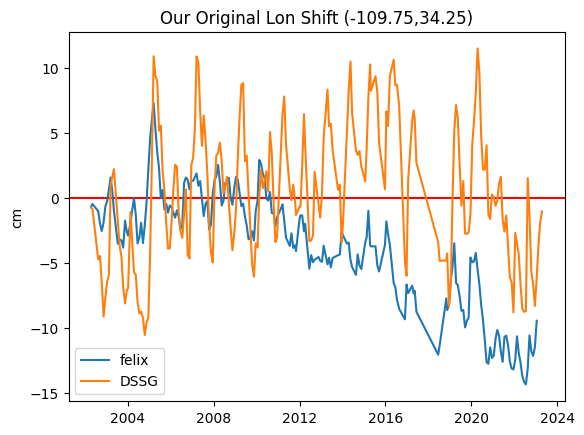

In [49]:
graph_pixel_df = pixel_df[['time', 'lwe_thickness']].groupby(['time']).mean().reset_index()

plt.axhline(0, color='red')
plt.plot(felix_df["DateTime"],felix_df['Water Equivalent Thickness – Land (GRACE, GRACE-FO JPL)'], label='felix')
plt.plot(graph_pixel_df["time"],graph_pixel_df["lwe_thickness"], label='DSSG')
plt.title("Our Original Lon Shift (-109.75,34.25)")
plt.legend()
plt.ylabel("cm")
plt.show()

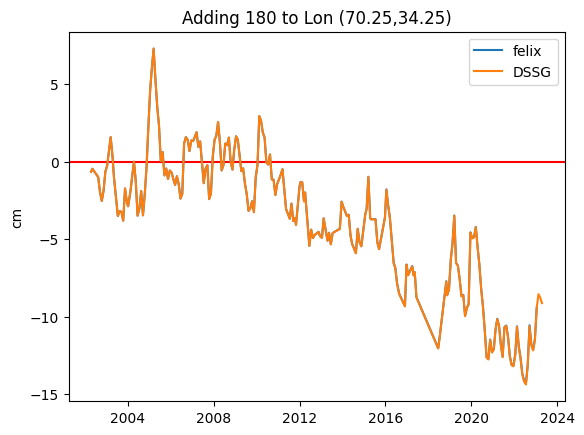

In [53]:
shift_pixel_df = grace_df[grace_df['lon_shift']==70.25]
shift_pixel_df = shift_pixel_df[shift_pixel_df['lat']==34.25]
shift_graph_pixel_df = shift_pixel_df[['time', 'lwe_thickness']].groupby(['time']).mean().reset_index()

shift_graph_pixel_df = shift_graph_pixel_df[['time', 'lwe_thickness']].groupby(['time']).mean().reset_index()

plt.axhline(0, color='red')
plt.plot(felix_df["DateTime"],felix_df['Water Equivalent Thickness – Land (GRACE, GRACE-FO JPL)'], label='felix')
plt.plot(shift_graph_pixel_df["time"],shift_graph_pixel_df["lwe_thickness"], label='DSSG')
plt.title("Adding 180 to Lon (70.25,34.25)")
plt.legend()
plt.ylabel("cm")
plt.show()

In [6]:
# There is no scale factor file I can find, let's do without first. 
# need to create an average grid value for each grid over the time period (Jan 2003-Nov 2013)

#period_df = crb_df[crb_df['time'].dt.strftime('%Y-%m-%d') <= "2013-11-31"]
#period_df = period_df[period_df['time'].dt.strftime('%Y-%m-%d') >= "2003-01-01"]
period_df=crb_df
period_df['lon/lat']=period_df['lat'].astype(str) + period_df['lon'].astype(str) 



In [7]:
period_df

,lon,lat,time,lwe_thickness,uncertainty,lon/lat
22202,-118.5,31.5,2017-06-11,-0.030972,0.031449,31.5-118.5
22204,-118.5,32.5,2017-06-11,-0.028578,0.031383,32.500000000000014-118.5
22206,-118.5,33.5,2017-06-11,-0.024512,0.031318,33.5-118.5
22208,-118.5,34.5,2017-06-11,-0.015148,0.031249,34.500000000000014-118.5
22210,-118.5,35.5,2017-06-11,0.000866,0.031173,35.50000000000001-118.5
...,...,...,...,...,...,...
27976,-102.5,38.5,2002-04-18,-0.037268,0.023613,38.49999999999999-102.5
27978,-102.5,39.5,2002-04-18,-0.009854,0.023616,39.50000000000001-102.5
27980,-102.5,40.5,2002-04-18,0.015778,0.023637,40.49999999999999-102.5
27982,-102.5,41.5,2002-04-18,0.029913,0.023670,41.500000000000014-102.5


In [213]:
"""
import math

period_df['index1']=period_df.index

surface_area_array = np.array([(6378160)*math.radians(1)*(6378160)*math.radians(1)*math.cos(math.radians(lat)) for lat in period_df.lat.values])
test = pd.DataFrame(surface_area_array, columns=['surface_area'])
test['index1']=test.index
#surface_area_array = np.array([6371000*math.radians(grace_coords['lat_interval_size'])*6371000*math.radians(grace_coords['lon_interval_size'])*math.cos(math.radians(grace_coords['lat']))])
ds_test = period_df.merge(test)
ds_test = ds_test[['lon','lat','surface_area']].drop_duplicates()
ds_test
"""

"\nimport math\n\nperiod_df['index1']=period_df.index\n\nsurface_area_array = np.array([(6378160)*math.radians(1)*(6378160)*math.radians(1)*math.cos(math.radians(lat)) for lat in period_df.lat.values])\ntest = pd.DataFrame(surface_area_array, columns=['surface_area'])\ntest['index1']=test.index\n#surface_area_array = np.array([6371000*math.radians(grace_coords['lat_interval_size'])*6371000*math.radians(grace_coords['lon_interval_size'])*math.cos(math.radians(grace_coords['lat']))])\nds_test = period_df.merge(test)\nds_test = ds_test[['lon','lat','surface_area']].drop_duplicates()\nds_test\n"

In [214]:
#merge_df = period_df.merge(ds_test, on=['lon','lat'])

In [215]:
#merge_df

In [180]:
# let's incorporate surface water: 
#merge_df['surfacearea_estimate'] = (merge_df['lwe_thickness'] * merge_df['surface_area'])/(10e9) # m * m ^2

In [200]:
#merge_df

In [216]:
"""
grid_area_df = period_df[['lon/lat', 'lwe_thickness']].groupby(['lon/lat']).mean().reset_index()
grid_area_df["grid_mean"] = grid_area_df['lwe_thickness']
grid_area_df = grid_area_df[['lon/lat','grid_mean']]
grid_area_df
"""

'\ngrid_area_df = period_df[[\'lon/lat\', \'lwe_thickness\']].groupby([\'lon/lat\']).mean().reset_index()\ngrid_area_df["grid_mean"] = grid_area_df[\'lwe_thickness\']\ngrid_area_df = grid_area_df[[\'lon/lat\',\'grid_mean\']]\ngrid_area_df\n'

In [217]:
"""
final_df = period_df.merge(grid_area_df, how="left", on='lon/lat')

final_df['final_estimate'] = final_df['lwe_thickness']-final_df['grid_mean']
final_df['final_estimate_m'] = 100*final_df['final_estimate']
final_df
"""

'\nfinal_df = period_df.merge(grid_area_df, how="left", on=\'lon/lat\')\n\nfinal_df[\'final_estimate\'] = final_df[\'lwe_thickness\']-final_df[\'grid_mean\']\nfinal_df[\'final_estimate_m\'] = 100*final_df[\'final_estimate\']\nfinal_df\n'

In [8]:
period_df['lwe_thickness_m'] = period_df['lwe_thickness']*100
graph_df = period_df[['time','lwe_thickness_m']]
graph_df = graph_df.groupby(['time']).mean().reset_index()

#graph_df = graph_df[graph_df['time'].dt.strftime('%Y-%m-%d') <= "2013-11-31"]
#graph_df = graph_df[graph_df['time'].dt.strftime('%Y-%m-%d') >= "2003-01-01"]

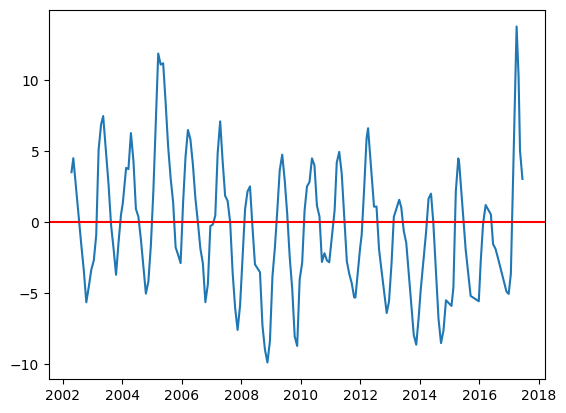

In [9]:
plt.plot('time', 'lwe_thickness_m', data=graph_df)
plt.axhline(0, color='red')
#plt.ylim(-.3,.3)
plt.show()

In [10]:
gfz_tws = pd.read_csv("../notebooks-and-markdowns/TWS_GFZOP_0600_tws_rivbas_Colorado River (Pacific Ocean)_0005.csv")

gfz_tws

,time [yyyy_doy],time [yyyy-mm-dd],Colorado River (Pacific Ocean) [cm],uncertainty_Colorado River (Pacific Ocean) [cm]
0,2002_108,2002-04-18,4.792168,1.070603
1,2002_130,2002-05-10,4.343762,0.955145
2,2002_228,2002-08-16,-1.105823,1.040225
3,2002_258,2002-09-15,-2.575215,0.879224
4,2002_289,2002-10-16,-2.355029,0.906572
...,...,...,...,...
208,2022_136,2022-05-16,-5.648277,1.406885
209,2022_167,2022-06-16,-7.879667,1.382330
210,2022_197,2022-07-16,-11.424164,1.424230
211,2022_228,2022-08-16,-12.701583,1.308465


In [11]:
from datetime import datetime

In [12]:
gfz_tws["time"] = [datetime.strptime(s,"%Y-%m-%d") for s in gfz_tws["time [yyyy-mm-dd]"]]

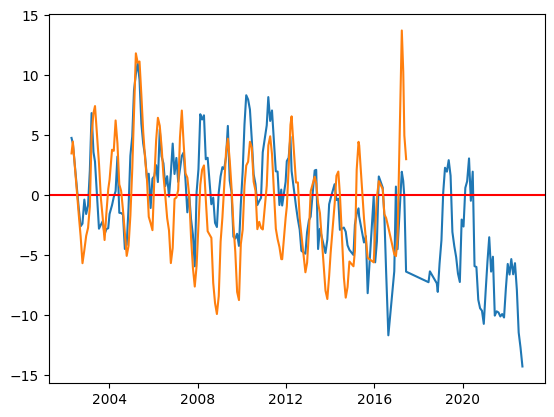

In [13]:
plt.plot(gfz_tws["time"],gfz_tws["Colorado River (Pacific Ocean) [cm]"])
plt.axhline(0, color='red')
plt.plot(graph_df["time"],graph_df["lwe_thickness_m"])
plt.show()

In [14]:
graph_df.describe()

,time,lwe_thickness_m
count,163,163.000000
mean,2009-07-11 03:45:16.564417280,-0.401184
min,2002-04-18 00:00:00,-9.885726
25%,2005-12-01 06:00:00,-3.597460
50%,2009-04-16 00:00:00,-0.634378
75%,2013-01-01 00:00:00,2.564512
max,2017-06-11 00:00:00,13.748940
std,NaN,4.594844


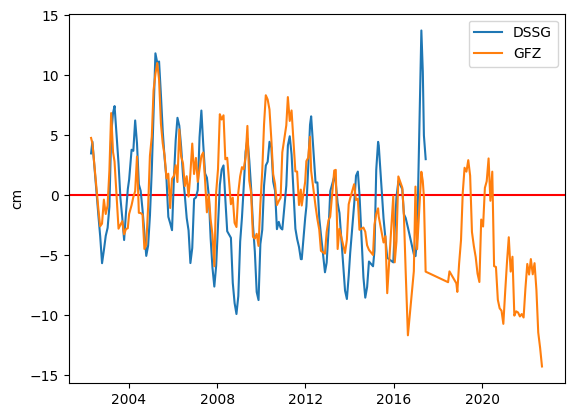

In [19]:
plt.axhline(0, color='red')
plt.plot('time', 'lwe_thickness_m', data=graph_df, label='DSSG')
plt.plot(gfz_tws['time'], gfz_tws['Colorado River (Pacific Ocean) [cm]'], label="GFZ")
plt.ylabel("cm")
#plt.ylim(-.3,.3)
plt.legend()
plt.show()


In [20]:
# Need to change this to relative path later
grace = xr.open_dataset("/home/kmk58/remoteData/GRACE_MASCON/data/TELLUS_GRAC-GRFO_MASCON_CRI_GRID_RL06.1_V3/GRCTellus.JPL.200204_202304.GLO.RL06.1M.MSCNv03CRI.nc") 

# print out grace data 
grace

<xarray.Dataset>
Dimensions:        (lon: 720, lat: 360, time: 220, bounds: 2)
Coordinates:
  * lon            (lon) float64 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
  * lat            (lat) float64 -89.75 -89.25 -88.75 ... 88.75 89.25 89.75
  * time           (time) datetime64[ns] 2002-04-17T12:00:00 ... 2023-04-16
Dimensions without coordinates: bounds
Data variables:
    lwe_thickness  (time, lat, lon) float64 ...
    uncertainty    (time, lat, lon) float64 ...
    lat_bounds     (lat, bounds) float64 ...
    lon_bounds     (lon, bounds) float64 ...
    time_bounds    (time, bounds) datetime64[ns] ...
    land_mask      (lat, lon) float64 ...
    scale_factor   (lat, lon) float64 ...
    mascon_ID      (lat, lon) float64 ...
Attributes: (12/53)
    Conventions:                   CF-1.6, ACDD-1.3, ISO 8601
    Metadata_Conventions:          Unidata Dataset Discovery v1.0
    standard_name_vocabulary:      NetCDF Climate and Forecast (CF) Metadata ...
    title:                         JPL GRACE and GRACE-FO MASCON RL06.1Mv03 CRI
    summary:                       Monthly gravity solutions from GRACE and G...
    keywords:                      Solid Earth, Geodetics/Gravity, Gravity, l...
    ...                            ...
    C_30_substitution:             TN-14; Loomis et al., 2019, Geophys. Res. ...
    user_note_1:                   The accelerometer on the GRACE-B spacecraf...
    user_note_2:                   The accelerometer on the GRACE-D spacecraf...
    journal_reference:             Watkins, M. M., D. N. Wiese, D.-N. Yuan, C...
    CRI_filter_journal_reference:  Wiese, D. N., F. W. Landerer, and M. M. Wa...
    date_created:                  2023-06-28T21:06:45Z

In [21]:
# transforming to dataframe and selecting relevant vars
grace_df = grace[['lon','lat','time','lwe_thickness','uncertainty','scale_factor']].to_dataframe()
grace_df.reset_index(inplace=True)
grace_df.reset_index(drop=True)
grace_df = grace_df.drop_duplicates()

#subsetting to rectangle containing the Colorado River Basin
grace_df["lon"] = grace_df["lon"] - 180  # converting longitude points

grace_df = grace_df[(grace_df.lon> lon_min) & (grace_df.lon < lon_max)]
grace_df = grace_df[(grace_df.lat> lat_min) & (grace_df.lat < lat_max)]

grace_df

,lon,lat,time,lwe_thickness,uncertainty,scale_factor
9715640,-118.75,31.25,2002-04-17 12:00:00,1.135869,2.638984,1.603936
9715641,-118.75,31.25,2002-05-10 12:00:00,1.167702,2.103443,1.603936
9715642,-118.75,31.25,2002-08-16 12:00:00,1.007997,1.662054,1.603936
9715643,-118.75,31.25,2002-09-16 00:00:00,0.214690,2.150112,1.603936
9715644,-118.75,31.25,2002-10-16 12:00:00,0.542129,1.425143,1.603936
...,...,...,...,...,...,...
12334735,-102.25,43.25,2022-12-16 12:00:00,-8.107416,1.184209,2.189324
12334736,-102.25,43.25,2023-01-16 12:00:00,-7.207149,1.448307,2.189324
12334737,-102.25,43.25,2023-02-15 00:00:00,-6.630485,1.746566,2.189324
12334738,-102.25,43.25,2023-03-16 12:00:00,-7.038567,2.052503,2.189324


In [22]:
grace_df[grace_df['lwe_thickness'].isna()]

,lon,lat,time,lwe_thickness,uncertainty,scale_factor


In [23]:
grace_df.sort_values(by='time', inplace=True)
grace_df['new_lwe'] = grace_df['lwe_thickness'] * grace_df['scale_factor'] 
grace_df

,lon,lat,time,lwe_thickness,uncertainty,scale_factor,new_lwe
9715640,-118.75,31.25,2002-04-17 12:00:00,1.135869,2.638984,1.603936,1.821861
11458480,-107.75,32.25,2002-04-17 12:00:00,7.364322,14.865509,0.509262,3.750371
11458700,-107.75,32.75,2002-04-17 12:00:00,7.364322,14.865509,0.509262,3.750371
11458920,-107.75,33.25,2002-04-17 12:00:00,7.364322,14.865509,0.682281,5.024540
11459140,-107.75,33.75,2002-04-17 12:00:00,7.364322,14.865509,0.682281,5.024540
...,...,...,...,...,...,...,...
11460019,-107.75,35.25,2023-04-16 00:00:00,-6.318313,8.447631,1.251672,-7.908456
11459799,-107.75,34.75,2023-04-16 00:00:00,-6.318313,8.447631,0.990343,-6.257299
11459579,-107.75,34.25,2023-04-16 00:00:00,-21.944085,6.949303,1.469034,-32.236599
11538559,-107.25,33.75,2023-04-16 00:00:00,-21.944085,6.949303,0.682281,-14.972040


In [24]:
grace_graph_df = grace_df[['time','new_lwe']]
grace_graph_df = grace_graph_df.groupby(['time']).mean().reset_index()

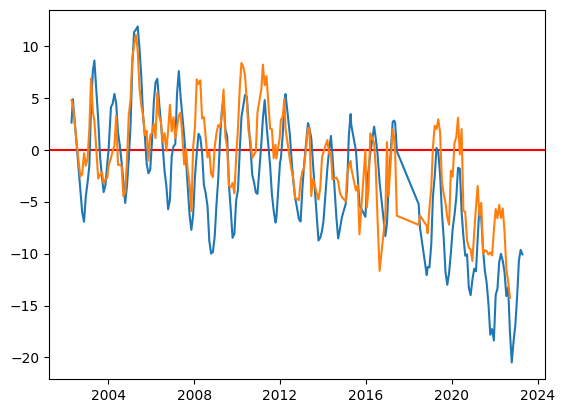

In [25]:
plt.axhline(0, color='red')
plt.plot('time', 'new_lwe', data=grace_graph_df)
plt.plot(gfz_tws['time'], gfz_tws['Colorado River (Pacific Ocean) [cm]'])
#plt.ylim(-.3,.3)
plt.show()

In [33]:
# the missing dates issue 
time_grace = grace_df['time'].drop_duplicates()
grace_df = grace_df[grace_df['time'].dt.strftime('%Y-%m-%d') <= "2022-09-31"]


In [35]:
time_grace = grace_df['time'].drop_duplicates()
time_grace

9715640    2002-04-17 12:00:00
10588381   2002-05-10 12:00:00
12334522   2002-08-16 12:00:00
10508523   2002-09-16 00:00:00
10591684   2002-10-16 12:00:00
                   ...        
11145848   2022-05-16 12:00:00
9718929    2022-06-16 00:00:00
10906490   2022-07-16 12:00:00
9718051    2022-08-16 12:00:00
11142112   2022-09-16 00:00:00
Name: time, Length: 213, dtype: datetime64[ns]

In [34]:
time_gfz = gfz_tws['time'].drop_duplicates()
time_gfz

0     2002-04-18
1     2002-05-10
2     2002-08-16
3     2002-09-15
4     2002-10-16
         ...    
208   2022-05-16
209   2022-06-16
210   2022-07-16
211   2022-08-16
212   2022-09-16
Name: time, Length: 213, dtype: datetime64[ns]

Recall the earlier graph: 

<p align="center">
    <img src="../notebooks-and-markdowns/whole_basin_castlepaper.png" width="800" />
</p>
